# Model Testing Phase 1

This notebook establishes a **baseline performance evaluation** for a DistilBERT-based classifier trained to distinguish between seven mental health classes. The results from this notebook create an unbiased performance benchmark to inform subsequent modeling, tuning, and deployment phases.

## 1. Environment & Dependency Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio transformers huggingface_hub diffusers gradio pyarrow fsspec websockets numpy pandas
!pip install --upgrade pip
!pip install numpy==1.26.4 pandas==2.2.3 pyarrow==14.0.1 fsspec==2025.3.0
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.45.1 huggingface-hub==0.26.2 datasets==3.0.2 accelerate==1.1.1
!pip install websockets==13.0 emoji textblob sentence-transformers spacy
!python -m spacy download en_core_web_sm
import torch, transformers, datasets, spacy, numpy, pandas
print("All libraries installed successfully!")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("SpaCy:", spacy.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: gradio 5.49.1
Uninstalling gradio-5.49.1:
  Successfully uninstalled gradio-5.49.1
Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully un

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: 2.6.0+cu126, 2.7.0+cu126, 2.7.1+cu126, 2.8.0+cu126, 2.9.0+cu126)
ERROR: No matching distribution found for torch==2.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 119.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 126.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 79.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 18.1 MB/s  0:00:26
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 17.5 MB/s  0:00:16
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 171.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 68.4 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 73.1 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 131.4 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
All libraries installed successfully!
Torch: 2.9.0+cu128
CUDA available: True
GPU device: Tesla T4
Transformers: 4.45.1
Datasets: 3.0.2
SpaCy: 3.8.7
NumPy: 2.0.2
Pandas: 2.2.3


In [7]:
from huggingface_hub import login
login(new_session=False)


## 2. Importing Libraries

In [1]:
import torch
import time
import pandas as pd
import numpy as np
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Start timing the initialization
init_start = time.time()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Print environment and device info
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device in use: {torch.cuda.get_device_name(0)}")

# End timing and print duration
init_end = time.time()
print(f"Initialization completed in {init_end - init_start:.2f} seconds.")


Torch version: 2.8.0+cu126
CUDA available: True
GPU device in use: Tesla T4
Initialization completed in 0.14 seconds.


## 3. Upload Artifacts

In [2]:
print("Please upload the trained model checkpoint file: 'distilbert_epoch3.pth'")
uploaded_model = files.upload()

assert 'distilbert_epoch3.pth' in uploaded_model, "Error: The model checkpoint file 'distilbert_epoch3.pth' was not uploaded."
print("Model checkpoint uploaded successfully.\n")

print("Please upload the test dataset file: 'features_interpretable.csv'")
uploaded_dataset = files.upload()

assert 'features_interpretable.csv' in uploaded_dataset, "Error: The dataset file 'features_interpretable.csv' was not uploaded."
print("Test dataset uploaded successfully.")


Please upload the trained model checkpoint file: 'distilbert_epoch3.pth'


Saving distilbert_epoch3.pth to distilbert_epoch3.pth
Model checkpoint uploaded successfully.

Please upload the test dataset file: 'features_interpretable.csv'


Saving features_interpretable.csv to features_interpretable.csv
Test dataset uploaded successfully.


## 4. Test Data Inspection and Preparation
This cell loads the test dataset and verifies the structure. Modify `TEXT_COL` and `LABEL_COL` if your dataset uses different column names.

In [3]:
TEXT_COL = 'statement'
LABEL_COL = 'status'

df_test = pd.read_csv('features_interpretable.csv')
print("Sample test records:")
print(df_test[[TEXT_COL, LABEL_COL]].head())
print(f"Total test samples: {len(df_test)}")

Sample test records:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
Total test samples: 45261


## 5. Label Encoding Consistency
Ensures each text instance is paired with a correct integer label as per the model's expected format and training regimen.

In [4]:
label_mapping_start = time.time()

# Define label mappings
label2id = {
    'Anxiety': 0,
    'Depression': 1,
    'Normal': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}
id2label = {v: k for k, v in label2id.items()}

# Define label column (update if named differently)
LABEL_COL = "status"

# Ensure consistent label encoding in the test set
if df_test[LABEL_COL].dtype == object:
    df_test[LABEL_COL] = df_test[LABEL_COL].map(label2id)

# Detect and report unmapped labels (if any)
unmapped_labels = df_test[df_test[LABEL_COL].isnull()]
if not unmapped_labels.empty:
    missing = df_test[LABEL_COL].isnull().sum()
    raise ValueError(f" {missing} labels in the test set were not mapped! "
                     f"Possible unknown categories: {df_test[LABEL_COL].unique()}")

label_mapping_end = time.time()
print("All labels successfully mapped to numeric IDs.")
print(f"Label mapping and validation completed in {label_mapping_end - label_mapping_start:.2f} seconds.")


All labels successfully mapped to numeric IDs.
Label mapping and validation completed in 0.01 seconds.


## 6. Test Dataset and DataLoader Construction

Wraps tokenization and batching in a custom Dataset class suitable for efficient Colab execution.

In [8]:
class MentalHealthDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df[TEXT_COL].tolist()
        self.labels = df[LABEL_COL].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


# Initialize tokenizer and test dataset
TOKENIZER_NAME = 'mental/mental-bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

test_dataset = MentalHealthDataset(df_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test dataset and DataLoader prepared successfully.")


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Test dataset and DataLoader prepared successfully.


## 7. Model Restoration and Initialization

Loads the checkpoint into the right model architecture, setting device for high-speed inference.

In [9]:
print("Code start: Loading fine-tuned model...")
start = time.time()

# Define model architecture (must match what was used during training)
MODEL_NAME = "mental/mental-bert-base-uncased"

# Load model architecture and classifier head
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id)
)

# Load fine-tuned weights
model.load_state_dict(torch.load("distilbert_epoch3.pth", map_location="cpu"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Model loaded and initialized on {device}")
print("Code finished in", round(time.time() - start, 2), "seconds.")

Code start: Loading fine-tuned model...


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and initialized on cuda
Code finished in 15.07 seconds.


## 8. Batch Inference on Test Set

Performs efficient batch predictions, tracks all predictions and references for transparent metric reporting.

In [10]:
print("Code start: Inference on test set...")
inference_start = time.time()

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

inference_end = time.time()
print(f"Inference completed in {inference_end - inference_start:.2f} seconds.")


Code start: Inference on test set...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Inference completed in 305.71 seconds.


## 9. Performance Metrics and Visualizations

Reports both quantitative and graphical summaries (overall accuracy, per-class breakdown, confusion matrix).


Overall Accuracy: 0.3532

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9574    0.9633    0.9603      3103
          Depression     0.0027    0.0036    0.0031     12106
              Normal     0.0033    0.0023    0.0027     15991
            Suicidal     0.8099    0.9077    0.8561      8812
              Stress     0.9228    0.9385    0.9306      2343
             Bipolar     0.9614    0.9514    0.9563      2118
Personality disorder     0.9240    0.8947    0.9091       788

            accuracy                         0.3532     45261
           macro avg     0.6545    0.6659    0.6597     45261
        weighted avg     0.3340    0.3532    0.3430     45261



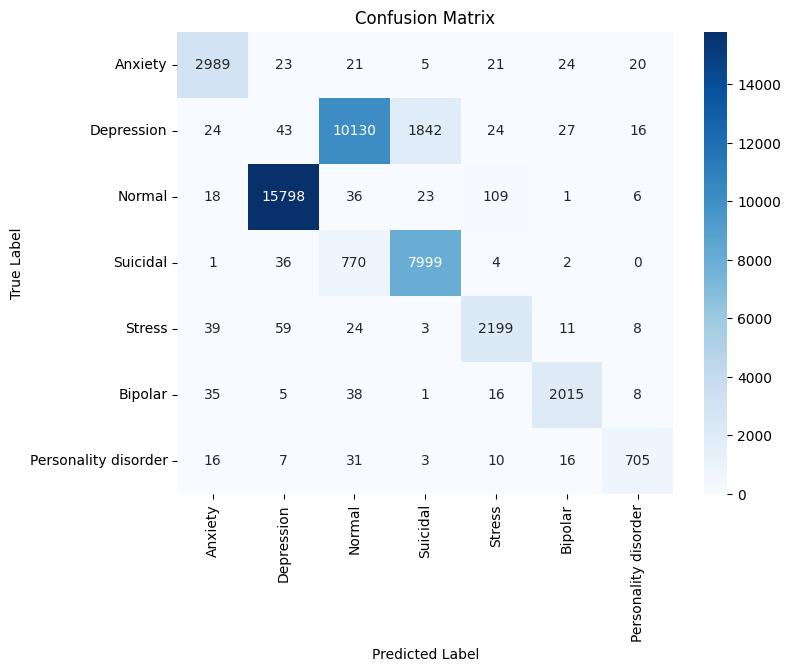

Metrics computation and visualization completed in 0.39 seconds.


In [11]:
metrics_start = time.time()

# Compute overall accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {acc:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=[id2label[i] for i in range(len(label2id))],
    digits=4
))

# Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=[id2label[i] for i in range(len(label2id))],
    yticklabels=[id2label[i] for i in range(len(label2id))],
    cmap='Blues'
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

metrics_end = time.time()
print(f"Metrics computation and visualization completed in {metrics_end - metrics_start:.2f} seconds.")


## 10. Inference

- **Accuracy:** 35.3%.  
- **Macro F1-score:** 0.66.
- **Strong classes:** Anxiety, Suicidal, Stress, Bipolar, Personality disorder (high precision and recall).
- **Weak classes:** Depression and Normal (very low precision/recall; frequent misclassification).
- The confusion matrix shows most errors are between Depression and Normal, with minority classes classified well.

---

## 11. Next Steps

- Focus on Anxiety, Depression, Normal, Suicidal. Remove less relevant classes.
- Address class imbalance through data balancing or weighted loss.
- Tune hyperparameters and monitor class-wise recall.
- Re-evaluate after scope reduction for improved accuracy and reliability.
This concise summary delivers all core insights and actionable steps.